In [96]:
# импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn import model_selection, metrics, compose, ensemble, preprocessing,  linear_model, svm, neighbors
import xgboost as xgb
import seaborn as sns
import scipy as sc
plt.style.use('ggplot')  # стиль для графиков

# Обзор датасета

In [2]:
# подгружаем данные
data=pd.read_csv('./src/data.csv')
data

,PriceNoTax,YearNum,Month_ID,BrandR1,SeazonClass,ConstrGroup,ExpositionType,CityType,OperatorR1,OperatorR2,BudgetClass,GRP,Latitude,Longitude,Population,Seller_Cat,Dis
0,17000.0,3,2,1.0,1,2,0,2,0,1,3,6.105542,55.457919,65.335799,312364.0,224,0.973449
1,17000.0,3,4,1.0,1,2,0,2,0,1,2,6.105542,55.457919,65.335799,312364.0,224,1.006239
2,21000.0,1,1,3.0,0,1,1,4,0,2,3,8.170000,55.159627,61.381623,1196680.0,268,1.136000
3,27000.0,3,4,1.0,1,2,0,2,0,1,2,3.750000,54.563482,36.298974,332039.0,209,1.131999
4,25000.0,2,8,1.0,1,2,1,4,2,4,3,2.303154,56.791160,60.572966,1493749.0,115,0.999160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13761,24000.0,1,9,1.0,2,2,0,3,2,3,1,3.290000,57.152781,65.620878,807271.0,120,1.098612
13762,18250.0,2,8,1.0,1,2,0,4,2,2,3,2.037000,57.992740,56.180762,1055397.0,222,0.996210
13763,10000.0,3,3,0.0,1,0,2,3,0,2,1,7.980000,57.143039,65.586761,807271.0,112,1.115142
13764,28000.0,2,8,1.0,1,2,0,4,0,1,3,2.434286,56.804553,60.650616,1493749.0,208,1.029619


**Описание полей**
- **PriceNoTax**: прайсовая цена конструкции
- **YearNum**: код года размещения
- **Month_ID**: код месяца размещения
- **BrandR1**: Категория бренда клиента:
 * 0: Глобальный
 * 1: Федеральный
 * 2: Региональный
 * 3: Локальный
- **SeazonClass**: 
 * 0: Низкий (январь, февраль, июнь, июль)
 * 1: Средний (март, апрель, май, август, сентябрь)
 * 2: Высокий (октябрь, ноябрь, декабрь)
- **ConstrGroup**: площадь конструкции:
 * 0: до 5 кв.м
 * 1: 5-15 кв.м
 * 2: 15-20 кв.м
 * 3: 20-100 кв.м
 * 4:более 100 кв.м
- **ExpositionType**: Тип конструкции
 * 0: Статика
 * 1: Тривижн
 * 2: Скроллер
 * 3: Диджитал
- **CityType**: Категория города размещения, в зависимости от населения
 * 0: более 4млн
 * 1: от 990 тыс
 * 2: от 440 тыс
 * 3: от 90 тыс
 * 4: от 45 тыс
 * 5: менее 45 тыс
- **OperatorR1**: география присутствия селлера
 * 0: Локальный
 * 1: Региональный
 * 2: Федеральный
- **OperatorR2**: масштаб селлера - количество конструкции в собственности
 * 0: до 100 конструкций
 * 1: 100-900 констр
 * 2: 900-4900 констр
 * 3: 4900 - 9900 констр
 * 4: более 9900 констр
- **Budget**: категория клиента в зависимости от  размеру рекламного бюджета
- **Latitude**: координаты конструкции (широта)
- **Longitude**: координаты конструкции (долгота)
- **Population**: население города размещения 
- **Seller_Cat**: закодированный селлер конструкции (мелкие селлеры объединены в одну группу 275) 
- **Dis**: целевая переменная: размер дисконта/надбавки к прайсовой цене

**Пару слов о препроцессинге**

Перед выгрузкой датасет был предварительно обработан, препроцесинг включал в себя:
- удаление дубликатов
- сброс NaN
- удаление выбросов: убрано порядка 1% записей, лежащих вне интервала [квантиль 0.25 - 1.5$*$IQR ; квантиль 0.75 + 1.5$*$IQR]
- обработка конфиденциальных данных: бюджеты клиентов и селлеры были закодированы, целевая переменная прошла трансформацию: сдвиг + мат. функция


# EDA

для предварительного анализа данных воспользуется таким прекрасным инструментом как pandas-profiling 

In [3]:
# установка последней версии
#!pip install pandas-profiling==3.3.0

In [4]:
import pandas_profiling
# формируем отчет
#pandas_profiling.ProfileReport(data)

Главное, что можно отметить в отчете:
- большинство переменных категориальные, понадобится кодировка
- если смотреть на корреляцию признаков, то кроме очевидных корреляций, вроде сезонности с номером месяца или прайсовой цены с размером конструкции, с которыми особо ничего не сделать, есть сильная корреляция между признаками **OperatorR1** и **OperatorR2**, а также между признаками **CityType** и **Population**. Для первого запуска модели оставим все как есть, но отбор признаков начнем с этой четверки.
- распределения признаков GRP и PriceNoTax, являются степенными, имеют длинные хвосты, распределение признака Population также имеет тяжелый хвосты с небольшим пиком в самом конце хвоста, целесообразно прологарифмирвать эти признаки, чтобы сгладить распределение

Категориальные признаки разбиваются на 3 группы:
- номинальные (Month_ID, YearNum, ExpositionType) их кодируем с помощью OneHotEncoding
- high-cardinality - с большим количеством уников (Seller_Cat), его закодируем с помощью LeaveOneOut
- ordinal (порядковые) все остальные (столбцы с 4 по 11 включительно за минусом ExpositionType), их оставим как есть, они уже закодированы порядковыми номерам

# Подготовка данных

In [5]:
# перемешиваем датасет
data =data.sample (frac=1 )

In [6]:
# разделим датасет на признаки и target
y= data.loc[:,'Dis']
X= data.drop ('Dis' , axis=1)

In [7]:
# для кодирования используем библиотеку category_encoders
#!pip install category_encoders
from category_encoders.one_hot import OneHotEncoder
from category_encoders.count import CountEncoder

ohe = OneHotEncoder (cols=['YearNum' , 'Month_ID' , 'ExpositionType'], use_cat_names=True)
X = ohe.fit_transform(X)

# используем частотное кодирование для категории Seller_Cat
coe = CountEncoder (cols=['Seller_Cat'] )
X = coe.fit_transform(X ,y)

In [8]:
# Определяем функцию трансформации - log(1+x) - и перезаписываем соответствующие столбцы датафрейма
tr = preprocessing.FunctionTransformer(np.log1p, validate=True)
col_tr = compose.make_column_transformer ((tr , ['PriceNoTax' , 'GRP' , 'Population']) )
X[['PriceNoTax' , 'GRP' , 'Population']] = col_tr.fit_transform(X)

# Тестирование моделей

In [9]:
# используем RandomForest в качестве baseline, получаем оценку R2 на кросс-валидации 
cvs = model_selection.cross_val_score (ensemble.RandomForestRegressor (), X, y,  cv=5, scoring='r2')
print ('RandomForest, R2 по фолдам ', cvs)
print ('RandomForest, R2 среднее' , round (cvs.mean() , 2))

RandomForest, R2 по фолдам  [0.8643028  0.88977103 0.8852352  0.87574931 0.8949753 ]
RandomForest, R2 среднее 0.88


In [10]:
# определим функцию, которая будет оценивать пользовательскую метрику (доля предсказаний превышающих допустимый
# интервал отклонения в 5 %)
def custom_loss (y_true, y_pred):
    diff=list(y_true-y_pred)
    list_d = [x for x in diff if x <-0.05 or x > 0.05]
    return len(list_d)/len(diff)*100
# и скорер, который можно использовать в кросс-валидации и оптимизации
custom_scorer = metrics.make_scorer(custom_loss, greater_is_better=False)

In [11]:
# получим оценку custom-loss на кросс-валидации 
cvs = model_selection.cross_val_score (ensemble.RandomForestRegressor (), X, y,  cv=5, scoring=custom_scorer)
print ('RandomForest, Custom_scor по фолдам ', np.negative (cvs) )
print ('RandomForest, Custom_scor' , round (np.negative (cvs.mean()) , 2))

RandomForest, Custom_scor по фолдам  [5.6281772  4.97638939 5.15800944 5.3396295  5.23065746]
RandomForest, Custom_scor 5.27


Чуть-чуть не дотягивает до нужного порога, посмотрим в сторону других моделей

In [12]:
# посмотрим насколько лучше отработает текущий стандарт ML обучения xgboost
cvs = model_selection.cross_val_score (xgb.XGBRegressor ( ), X, y,  cv=5, scoring='r2')
print ('Xgboost, R2 по фолдам ', cvs)
print ('Xgboost, R2 среднее' , round (cvs.mean() , 2))

Xgboost, R2 по фолдам  [0.83114955 0.85270267 0.84056867 0.82703476 0.84690712]
Xgboost, R2 среднее 0.84


R2 похуже, но это с дефолтными гиперпараметрами, пробуем подобрать параметры получше

In [13]:
# фиксируем learning rate, перебираем количество итераций и глубину деревьев 
params = {'n_estimators' : [500, 750, 1000, 1250] ,    'max_depth' :[5, 8, 11, 14, 17] }
gs= model_selection.GridSearchCV (xgb.XGBRegressor (learning_rate=0.03 ) , param_grid=params, scoring = 'r2' )

In [16]:
#gs.fit (X, y)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.03, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                   

In [17]:
gs.best_params_

{'max_depth': 11, 'n_estimators': 1250}

In [18]:
# используем найденные параметры
cvs = model_selection.cross_val_score (xgb.XGBRegressor ( learning_rate=0.03, max_depth=11, n_estimators=1250 ),
                                       X, y,  cv=5, scoring='r2')
print ('Xgboost, R2 по фолдам ', cvs)
print ('Xgboost, R2 среднее' , round (cvs.mean() , 2))

Xgboost, R2 по фолдам  [0.88602807 0.89828983 0.89504963 0.88600443 0.90314099]
Xgboost, R2 среднее 0.89


In [19]:
# теперь custom-loss на кросс-валидации 
cvs = model_selection.cross_val_score (xgb.XGBRegressor ( learning_rate=0.03, max_depth=11, n_estimators=1250 ),
                                       X, y,  cv=5, scoring=custom_scorer)
print ('Xgboost, Custom_scor по фолдам ', np.negative (cvs) )
print ('Xgboost, Custom_scor' , round (np.negative (cvs.mean()) , 2))

Xgboost, Custom_scor по фолдам  [4.50254176 4.54050127 4.54050127 5.23065746 4.43152924]
Xgboost, Custom_scor 4.65


Результаты немного лучше, чем у RandomForest, даже удалось попасть в требуемый порог 
Также по смыслу задачи должны хорошо сработать метрические модели, если поверхности расположены рядом, имеют похожий рейтинг и принадлежат одному и тому же селлеру, размер дисконта на них на них должен быть сопоставим

In [20]:
# тестим KNN с дефолтными параметрами 
cvs =model_selection.cross_val_score (neighbors.KNeighborsRegressor(), X, y,  cv=5, scoring='r2')
print ('KNN, R2 по фолдам ', cvs)
print ('KNN, R2 среднее' , round (cvs.mean() , 2))

KNN, R2 по фолдам  [0.76100947 0.76821839 0.77204582 0.76422184 0.76986948]
KNN, R2 среднее 0.77


In [21]:
# снова используя GridSearch получаем оптимальные гиперпараметры 
cvs =model_selection.cross_val_score (neighbors.KNeighborsRegressor(6, p=1, weights='distance'), X, y,  cv=5, scoring='r2')
print ('KNN, R2 по фолдам ', cvs)
print ('KNN, R2 среднее' , round (cvs.mean() , 2))

KNN, R2 по фолдам  [0.80526321 0.79671804 0.81929986 0.80398216 0.82152193]
KNN, R2 среднее 0.81


In [22]:
cvs =model_selection.cross_val_score (neighbors.KNeighborsRegressor(6, p=1, weights='distance'), X, y,  cv=5, scoring=custom_scorer)
print ('KNN, R2 по фолдам ', np.negative (cvs))
print ('KNN, R2 среднее' , round ( np.negative (cvs.mean()), 2))

KNN, R2 по фолдам  [8.20624546 9.55321467 8.75408645 8.49981838 8.71776244]
KNN, R2 среднее 8.75


Результат не дотягивает до RandomForest и Xgboost, но в дальнейшем эту модель можно попробовать использовать при стекинге.  
Примечание: вообще данные для метрических алгоритмов рекомендуется нормировать, но в данном случае оценка **R2** ухудшается при нормировании, на мой взгляд, это происходит по двум причинам:
- некоторые числовые признаки были предварительно прологарифмированы, соответственно, масштабировались до небольших значений 
- все признаки находятся примерно в одном масштабе, зак исключением признаков Seller_Cat и геокоординат, но они, по видимому, являются ключевыми для расчета прогноза, и немасштабированные данные содержат более точную информацию о расстониях между признаками, поэтому масштабирование и ухудшает качество прогноза


# Отбор признаков

Взглянем на то, какие признаки дают больший вклад в прогноз, а какие, возможно, вносят только шум.  
Вообще, изначально признаков в датасете очень немного и очень маловероятно, что потребуется какие-либо признаки исключать или проводить сокращения размерности признаков, но убедиться стоит

Text(0.5, 1.0, 'Feature_importance, Xgboost ')

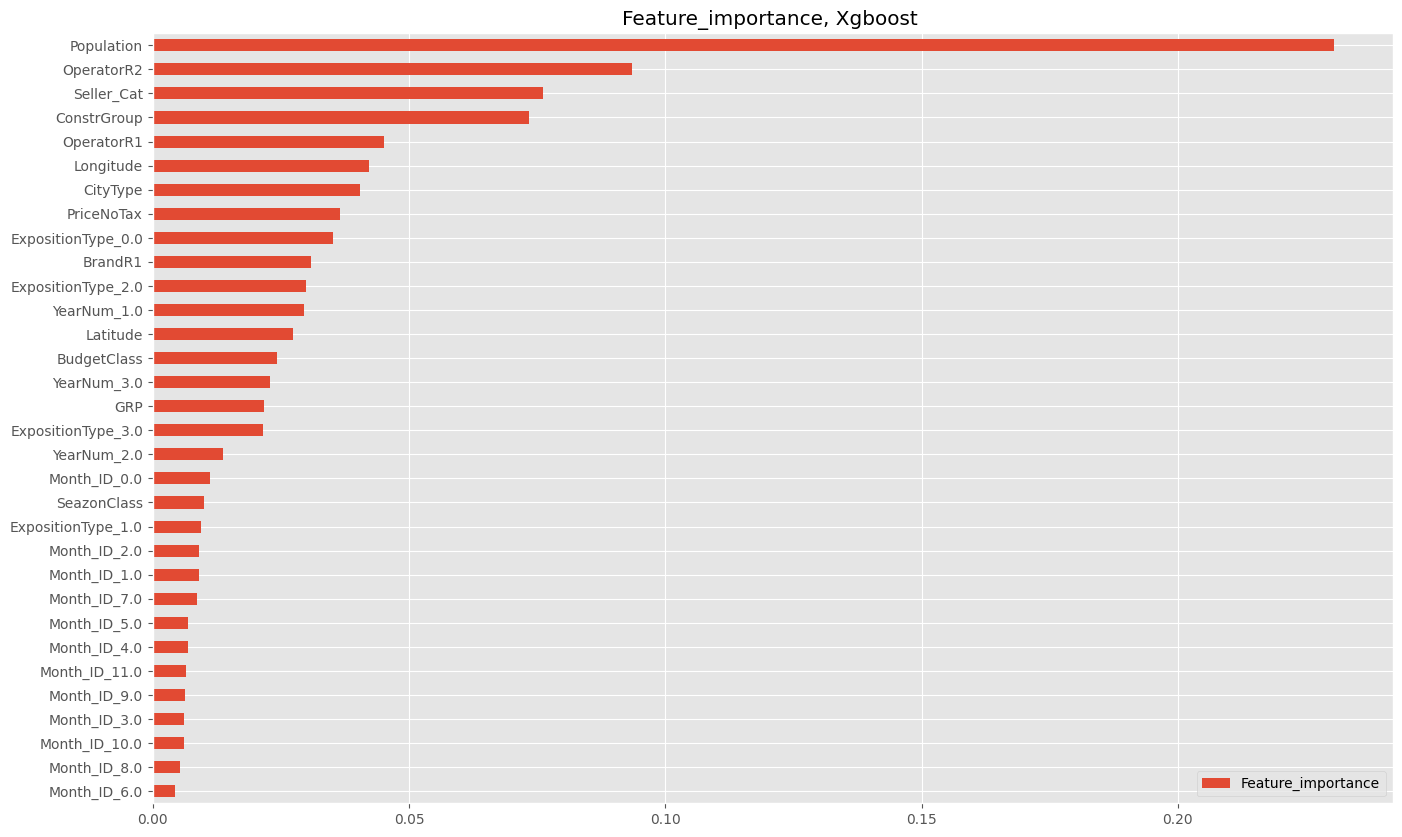

In [128]:
# воспользуемся атрибутом feature_importances_ эстиматора у ранне обученного объекта GridSearch
fi = pd.DataFrame (gs.best_estimator_.feature_importances_, columns=['Feature_importance'], index= X.columns.to_list()).sort_values('Feature_importance')
fi.plot.barh(figsize=(16,10))
plt.title ('Feature_importance, Xgboost ' );

<img src='./src/images/fi.png'>

Откровенно лишних признаков нет, более того, признаки с сильной корреляцией, которые были отмечены в разделе EDA оказались в топе признаков. Тем не менее, оценим как изменяется дисперсия остатков регресии, при исключении того или иного признака.

In [67]:
# делим на трейн / тест
X_train, X_test, y_train, y_test = model_selection.train_test_split ( X, y, train_size = 0.75 )

In [130]:
xbr=xgb.XGBRegressor (learning_rate=0.03, max_depth=11, n_estimators=1250)
xbr.fit ( X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1250,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

Text(0.5, 1.0, 'Распределение остатков регрессии')

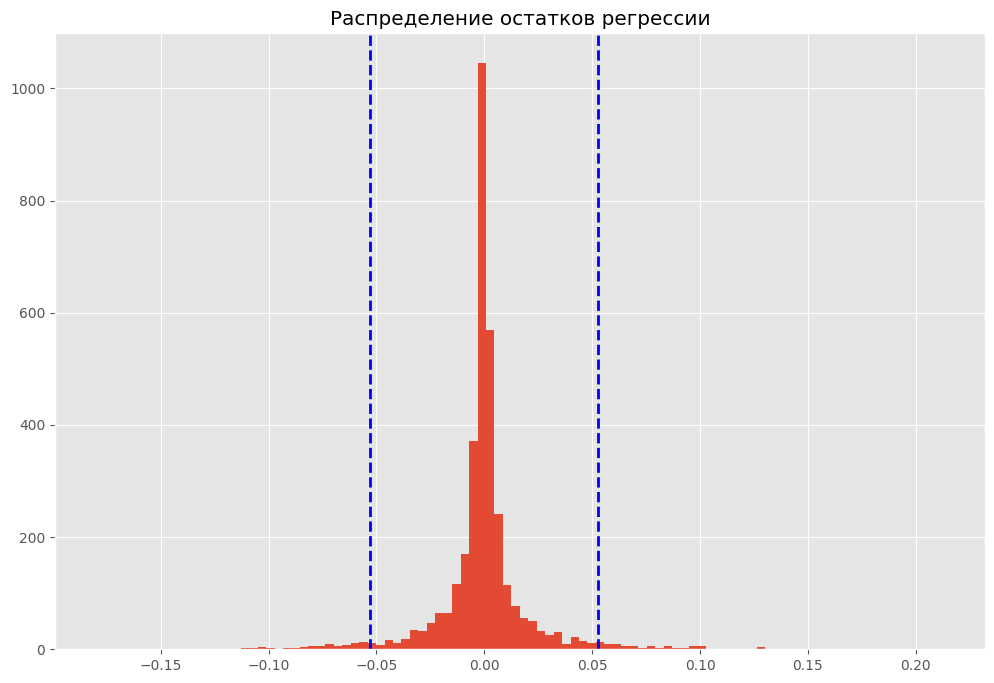

In [131]:
# посмотрим на остатки регресcии, нарисуем границы интервала, в которое укладывается 95% отклонений
residuals = y_test - xbr.predict (X_test )
fig = plt.figure (figsize=(12,8) )
plt.hist (residuals, bins=100);
left_int = residuals.quantile (0.025)
right_int = residuals.quantile (1- 0.025)
for i in [left_int, right_int]: 
        y_max = plt.ylim()[1]
        plt.axvline(i, color="blue", linestyle='dashed', lw=2)
plt.title ('Распределение остатков регрессии' );

In [105]:
# посчитаем среднеквадратичное отклонение (Std), которое станет бенчмарком
print ('Std - ' , round (residuals.std() , 4))

Std -  0.0231


In [108]:
# Попробуем поочередно убирать один признак и измерять Std остатков регресcии и записывать его в словарь
# Процесс занимает значительное количество времени, поэтому итоговый график вынесен отдельной картинкой

PriceNoTax
YearNum_1.0
YearNum_2.0
YearNum_3.0
Month_ID_2.0
Month_ID_3.0
Month_ID_8.0
Month_ID_7.0
Month_ID_6.0
Month_ID_1.0
Month_ID_9.0
Month_ID_11.0
Month_ID_0.0
Month_ID_5.0
Month_ID_10.0
Month_ID_4.0
BrandR1
SeazonClass
ConstrGroup
ExpositionType_1.0
ExpositionType_0.0
ExpositionType_2.0
ExpositionType_3.0
CityType
OperatorR1
OperatorR2
BudgetClass
GRP
Latitude
Longitude
Population
Seller_Cat
CPU times: total: 1h 26min 40s
Wall time: 21min 52s


In [109]:
#res={}
#res['bench'] = residuals.std()
#xbr1=xgb.XGBRegressor (learning_rate=0.03, max_depth=11, n_estimators=1250)
#for c in X.columns.to_list():
#  cl= X.columns.to_list()
#  cl.remove(c)
#  xbr1.fit (X_train.loc[:, cl], y_train)  
#  diff = y_test - xbr1.predict (X_test.loc[:, cl])
#  y_pred = xbr1.predict (X_test.loc[:, cl])
#  res[c] = diff.std()

{'bench': 0.02313492314639931,
 'PriceNoTax': 0.026424422505590645,
 'YearNum_1.0': 0.022657504332367472,
 'YearNum_2.0': 0.023250544376692356,
 'YearNum_3.0': 0.023195568169320592,
 'Month_ID_2.0': 0.023190687819386702,
 'Month_ID_3.0': 0.02301175625464923,
 'Month_ID_8.0': 0.022931476185112827,
 'Month_ID_7.0': 0.02278701420849759,
 'Month_ID_6.0': 0.023361950935819158,
 'Month_ID_1.0': 0.023152558796562195,
 'Month_ID_9.0': 0.02306741085641449,
 'Month_ID_11.0': 0.02303572798262646,
 'Month_ID_0.0': 0.023111877991865384,
 'Month_ID_5.0': 0.02301305406564679,
 'Month_ID_10.0': 0.02286380316730308,
 'Month_ID_4.0': 0.0232324250692154,
 'BrandR1': 0.023992443655000716,
 'SeazonClass': 0.023217944583721367,
 'ConstrGroup': 0.02348308741251936,
 'ExpositionType_1.0': 0.023060568528932818,
 'ExpositionType_0.0': 0.023093811783076432,
 'ExpositionType_2.0': 0.022848192812887257,
 'ExpositionType_3.0': 0.02310826011629764,
 'CityType': 0.023123977516042473,
 'OperatorR1': 0.0229274295118441

Text(0.5, 1.0, 'Std остатков регрессии, в зависимости от убранного признака ')

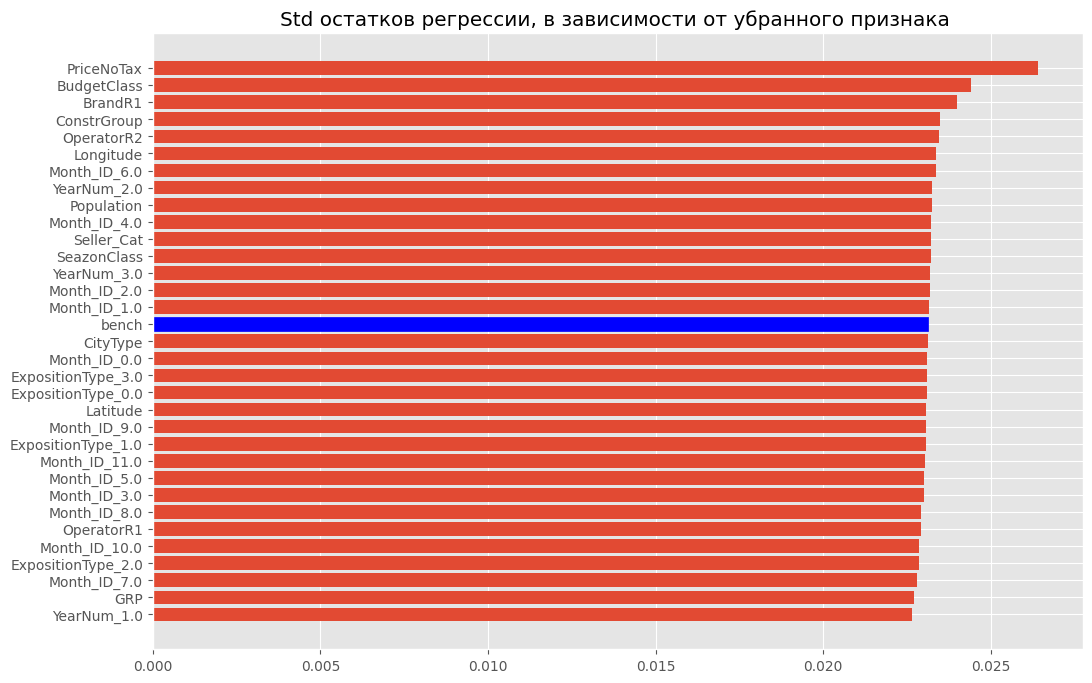

In [127]:
fe = pd.DataFrame.from_dict (res, orient='index' , columns=['Std']).sort_values ('Std')

In [ ]:
fig = plt.figure (figsize=(12,8) )
barviz = plt.barh ( fe.index , fe['Std'])
barviz[17].set_color('b')
plt.title ('Std остатков регрессии, в зависимости от убранного признака ' );

<img src='./src/images/fe.png'>

Попробуем убрать 3 признака, лежащих ниже бенчмарка: **OperatorR1** и **CityType**, которые мы отметили в разделе EDA и **GRP**, который находится внизу списка

Попробуем убрать 3 признака, лежащих ниже бенчмарка: **OperatorR1** и **CityType**, которые мы отметили в разделе EDA и **GRP**, который находится внизу списка

In [ ]:
X_trunc = X.drop (['GRP', 'OperatorR1' , 'CityType' ] , axis=1)

In [ ]:
cvs = model_selection.cross_val_score (xgb.XGBRegressor ( learning_rate=0.03, max_depth=11, n_estimators=1250 ),
                                       X_trunc, y,  cv=5, scoring='r2')
print ('Xgboost, R2 по фолдам ', cvs)
print (f'Xgboost, R2 среднее = {cvs.mean():.4f}')

In [ ]:
cvs = model_selection.cross_val_score (xgb.XGBRegressor ( learning_rate=0.03, max_depth=11, n_estimators=1250 ),
                                       X_tranc, y,  cv=5, scoring=custom_scorer)
print ('Xgboost, R2 по фолдам ', np.negative (cvs) )
print (f'Xgboost, R2 среднее =  {np.negative (cvs.mean()):.4f}')

Изменение к лучшему очень незначительные 

# Стекинг, блендинг

В заключение попробуем использовать стекинг, объединив предсказания Xgboost и KNN, возможно они дополнят друг друга

In [ ]:
X_train_1, X_test_1, y_train, y_test = model_selection.train_test_split ( X_trunc, y, train_size = 0.75 )

In [ ]:
est_list =  [ ('xgb', xgb.XGBRegressor ( learning_rate=0.03, max_depth=11, n_estimators=1250 )),
             ('knn', neighbors.KNeighborsRegressor(6, p=1, weights='distance')) ]

In [ ]:
stc = ensemble.StackingRegressor(est_list, final_estimator=ensemble.RandomForestRegressor ( ) , cv=5)
stc.fit (X_train_1, y_train)
print (f'Stacking, R2  =  {metrics.r2_score (y_test, stc.predict (X_test_1)):.4f}') 

Объединение прогнозов двух моделей не смогло превзойти Xgboost

In [ ]:
xbr  = xgb.XGBRegressor (learning_rate=0.03, max_depth=11, n_estimators=1250)
xbr.fit ( X_train_1, y_train)

In [ ]:
metrics.r2_score (y_test, xbr.predict (X_test_1))

In [ ]:
# Итоги